In [55]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score, auc, roc_curve,f1_score
from sklearn.model_selection import GridSearchCV

In [34]:
data = pd.read_csv('data.csv')
# уберем фичи, которые не используются для задания 
unused_features = ['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1',
                   'coeff_sum0', 'coeff_sum1']
data.drop(columns=unused_features, inplace=True)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


In [35]:
def analysis(data: pd.DataFrame):
    # общая инфомарция 
    print("Типы данных в датасете:")
    data.info()
    print("-----------------------------------------------")
    print("Основные характеристики данных:", data.describe(), sep='\n')
    print("-----------------------------------------------")
    print(f"Данные были собраны с {str(pd.to_datetime(data['date_time']).min().date())} по {str(pd.to_datetime(data['date_time']).max().date())}")
    print("-----------------------------------------------")
    print("Рассмотрим, сколько уникальных значений есть в каждом признаке")
    print(data.drop(columns='date_time').nunique())
    print("-----------------------------------------------")
    print(f"Количество повторяющихся значений признаков: {len(data[data.duplicated()])}")
    print(f"Количество нулевых значений признаков: {data.isna().sum().sum()}")
    
    # матрица корреляций
    correlation_matrix = data.drop(columns='date_time').corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm").set(title='Матрица корреляций')
    print("-----------------------------------------------")
    print("Рассмотрим матрицу корреляций:")
    plt.show()
    
    # распределение фич 
    print("-----------------------------------------------")
    print("Рассмотрим распределение признаков:")
    for i in data.drop(columns='date_time').columns:
        plt.figure(figsize=(10, 6))
        plt.hist(data[i], bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Распределение значений в столбце "{i}"')
        plt.xlabel(f'Значение {i}')
        plt.ylabel('Частота')
        plt.show()
    
    # рассмотрим отдельно распределение zone_id, campaign_clicks, banner_id, 
    # т.к. у них наибольшее количество уникальных значений
    print("-----------------------------------------------")
    print("Рассмотрим распределение campaign_clicks, zone_id и banner_id:")  
    print("кол-во уникальных значений в banner_id:", data['banner_id'].value_counts(), sep='\n')
    print("кол-во уникальных значений в zone_id:", data['zone_id'].value_counts(), sep='\n')
    print("кол-во уникальных значений в campaign_clicks:", data['campaign_clicks'].value_counts(), sep='\n')


Типы данных в датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15821472 entries, 0 to 15821471
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   date_time        object
 1   zone_id          int64 
 2   banner_id        int64 
 3   campaign_clicks  int64 
 4   os_id            int64 
 5   country_id       int64 
 6   impressions      int64 
 7   clicks           int64 
dtypes: int64(7), object(1)
memory usage: 965.7+ MB
-----------------------------------------------
Основные характеристики данных:
            zone_id     banner_id  campaign_clicks         os_id   
count  1.582147e+07  1.582147e+07     1.582147e+07  1.582147e+07  \
mean   8.152679e+01  3.816483e+02     6.238540e-01  1.840605e+00   
std    1.632448e+02  3.959386e+02     9.249152e+00  1.530005e+00   
min    0.000000e+00  0.000000e+00     0.000000e+00  0.000000e+00   
25%    1.400000e+01  5.200000e+01     0.000000e+00  1.000000e+00   
50%    1.900000e+01  2.170000e+0

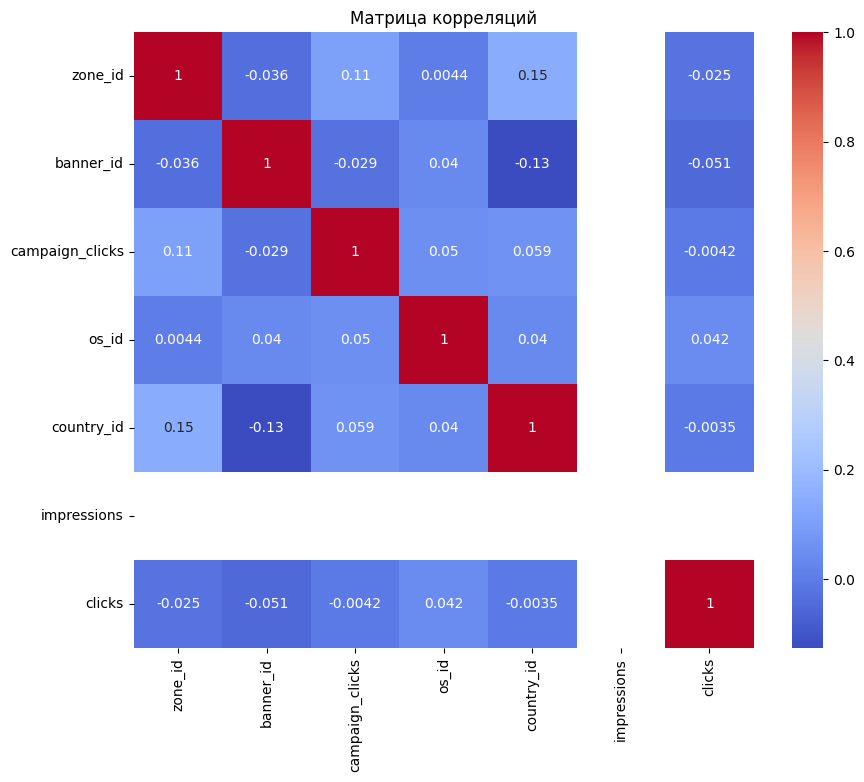

-----------------------------------------------
Рассмотрим распределение признаков:


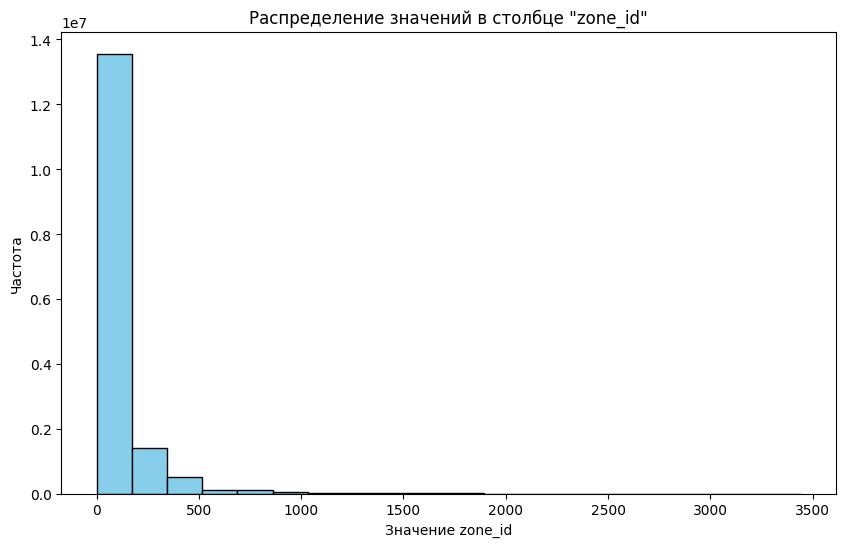

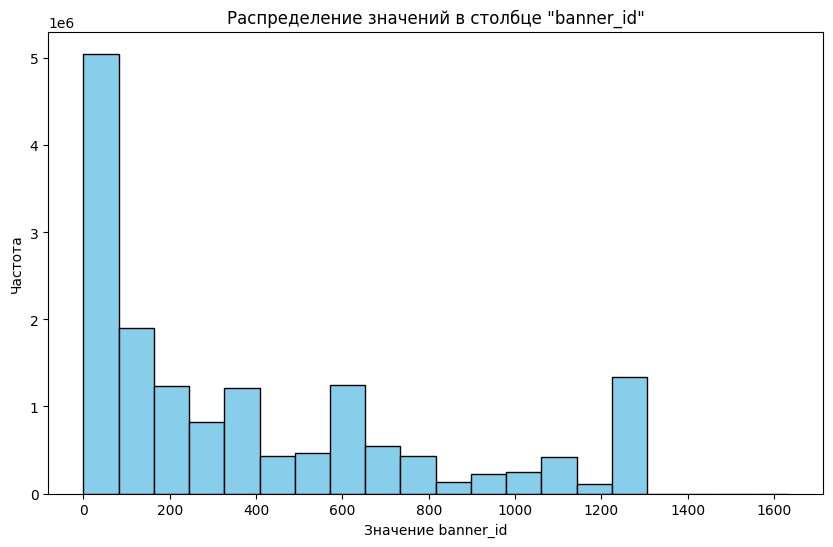

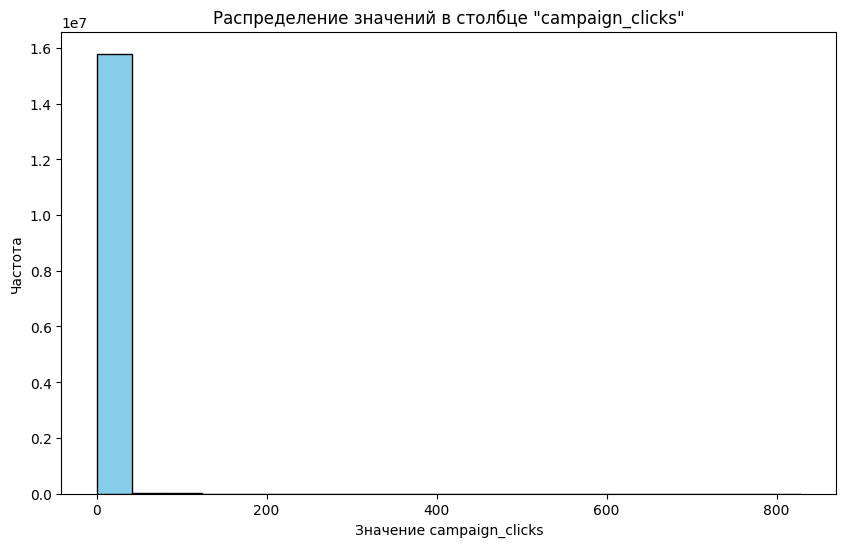

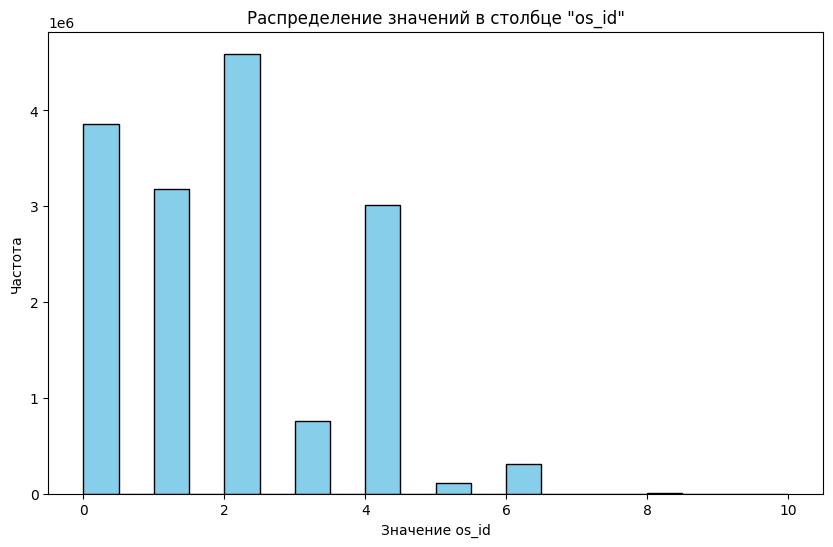

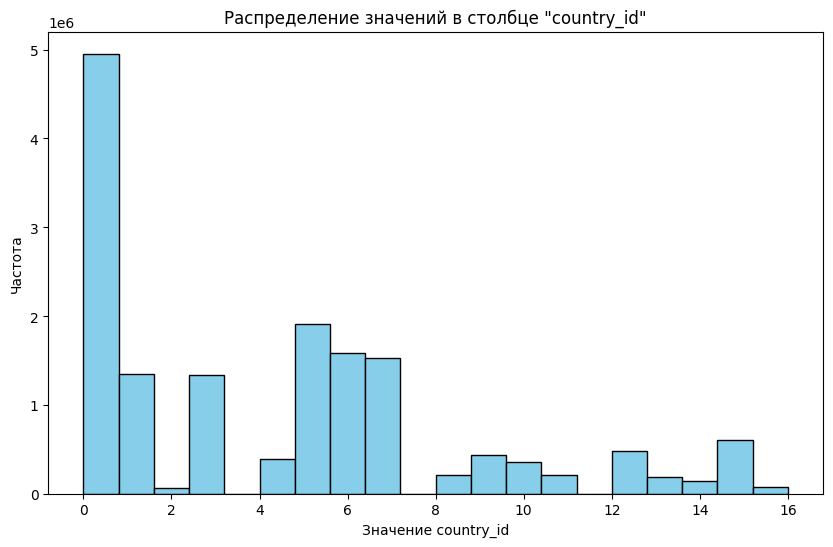

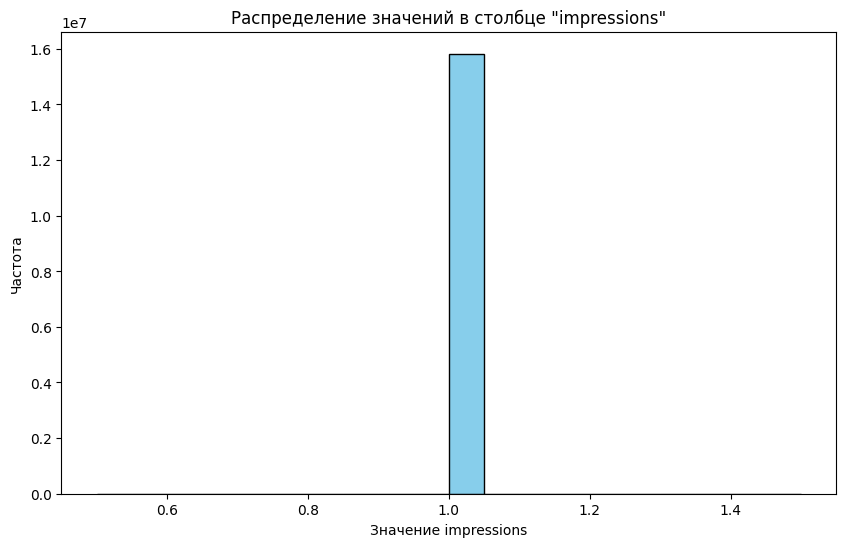

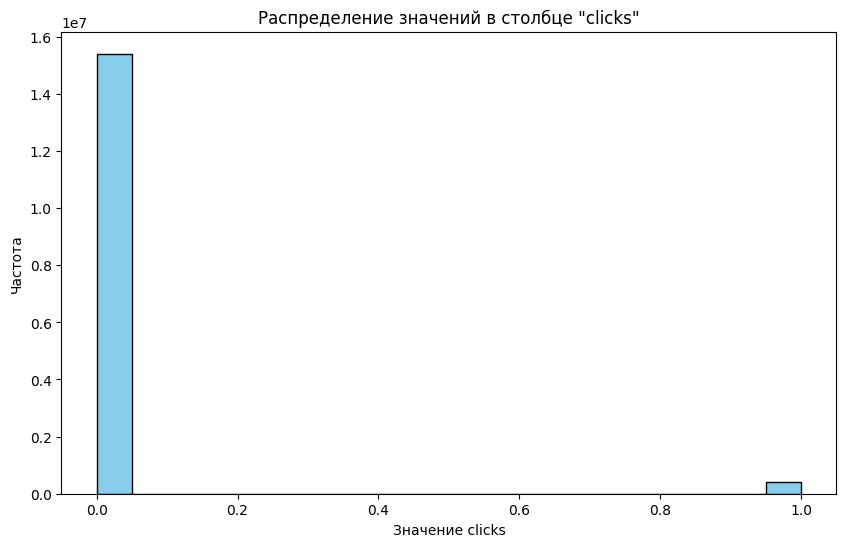

-----------------------------------------------
Рассмотрим распределение campaign_clicks, zone_id и banner_id:
кол-во уникальных значений в banner_id:
banner_id
22      613367
361     387563
3       286999
18      262946
21      246378
         ...  
1501         1
1503         1
1504         1
1507         1
1632         1
Name: count, Length: 1633, dtype: int64
кол-во уникальных значений в zone_id:
zone_id
17      2280422
14      1638642
12       736352
0        708379
19       693292
         ...   
2186          1
2188          1
2518          1
2962          1
3443          1
Name: count, Length: 3444, dtype: int64
кол-во уникальных значений в campaign_clicks:
campaign_clicks
0      13682452
1       1236822
2        342937
3        173528
4        100293
         ...   
791           1
829           1
820           1
803           1
828           1
Name: count, Length: 822, dtype: int64


In [8]:
analysis(data)

# Выводы анализа: 
1. cтолбец "impressions" полностью состоит из единиц, следовательно, не несет никакой информации;
2. в данных имеются дубликаты; 
3. столбец "date_time" имеет неверный формат. Его нужно перевести в правильный формат и разбить на несколько измерений: часы, часть суток, день недели - так он будет более информативным;
4. между признаками нет явной корреляции как друг с другом, так и с целевой переменной;
5. признаки "zone_id" и "campaign_clicks" имеют уникальные категории, которые встречаются намного чаще остальных. Распределение признака "banner_id" более равномерное, поэтому не будем с ним работать, а с "campaign_clicks" я не придумала, что можно сделать:(. Для "zone_id" предлагаю редкие значения объединить в "-1". 
6. целевая переменная "clicks" тоже неравномерно распределена, что может вызвать трудности с классификацией в дальнейшем. 

In [36]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # 1 - убираем impressions
    data.drop(columns='impressions', inplace=True)
    
    # 2 - убираем дубликаты 
    data.drop_duplicates(inplace=True)

    # 3 - преобразовываем date_time
    data['date_time'] = pd.to_datetime(data['date_time'])
    data['week_day'] = data['date_time'].dt.dayofweek + 1
    data['quarter_of_day'] = (data['date_time'].dt.hour // 6) + 1
    data['hour_day'] = (data['date_time'].dt.hour).astype('int64')
    
    # В zone_id есть значения, которые встречаются больше 2M раз, а есть значения, которые 
    # встречаются лишь единожды. Объединим редкие значения в одно, чтобы модель не считывала эти значения 
    # как выбросы и могла лучше обощаться в будущем. Пусть этим значением будет "-1"
    threshold = 20000 
    value_counts_zone_id = data['zone_id'].value_counts()
    rare_values = value_counts_zone_id[value_counts_zone_id <= threshold].index
    data['zone_id'] = data['zone_id'].apply(lambda x: -1 if x in rare_values else x)

    return data

In [37]:
data = feature_engineering(data)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,week_day,quarter_of_day,hour_day
0,2021-09-27 00:01:30,0,0,0,0,0,1,1,1,0
1,2021-09-26 22:54:49,1,1,0,0,1,1,7,4,22
2,2021-09-26 23:57:20,2,2,3,0,0,1,7,4,23
3,2021-09-27 00:04:30,3,3,0,1,1,1,1,1,0
4,2021-09-27 00:06:21,-1,4,0,1,0,1,1,1,0


In [38]:
# вытащим последний день - пусть это будет тестовыми данными
test_data = data[pd.to_datetime(data['date_time']) == '2021-10-02']
print(f"Кол-во тестовых данных: {len(test_data)}")
data.drop(index=test_data.index, inplace=True)
test_data.reset_index(inplace=True)
data.reset_index(inplace=True)
X_test, y_test = test_data.drop(['clicks', 'date_time'], axis=1), test_data['clicks']
print(f"Классы в y_test: {y_test.unique()}")

# разделим данные на тренировочную и тестовую выборку 
X = data.drop(['clicks', 'date_time'], axis=1)
y = data['clicks']
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)


Кол-во тестовых данных: 18
Классы в y_test: [0]


In [61]:
def create_model(data):
    model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs', 
                                   penalty='l2', fit_intercept=False, verbose=1)
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_validate)
    y_prob_val = model.predict_proba(X_validate)[:, 1]

    accuracy = accuracy_score(y_validate, y_pred_val)
    logloss = log_loss(y_validate, y_prob_val)
    roc_auc = roc_auc_score(y_validate, y_prob_val)

    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation Log Loss: {logloss:.4f}")
    print(f"Validation ROC AUC: {roc_auc:.4f}")
    print("Validation Classification Report:\n", classification_report(y_validate, y_pred_val))

    fpr, tpr, _ = roc_curve(y_validate, y_prob_val)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print("Рассмотрим тестовые данные (последний день) и сравним наши результаты с бейзлайном")
    
    # в baseline есть только нулевые значения, поэтому нельзя посчитать log_loss и roc_auc, будем
    # смотреть accuracy

    baseline = (y_test == 0).sum() / len(y_test)
    print(f"Baseline accuracy: {baseline}")

    y_pred_test = model.predict(X_test)
    print(f'Logistic Regression accuracy: {accuracy_score(y_test, y_pred_test)}')
    
    return model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42945D+06    |proj g|=  4.74339D+13


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.6s finished



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     57      1     0     0   2.650D+06   4.555D+05
  F =   455452.74999072374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Validation Accuracy: 0.9783
Validation Log Loss: 0.0375
Validation ROC AUC: 0.9952
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99   2957371
           1       0.97      0.21      0.35     82912

    accuracy                           0.98   3040283
   macro avg       0.97      0.60      0.67   3040283
weighted avg       0.98      0.98

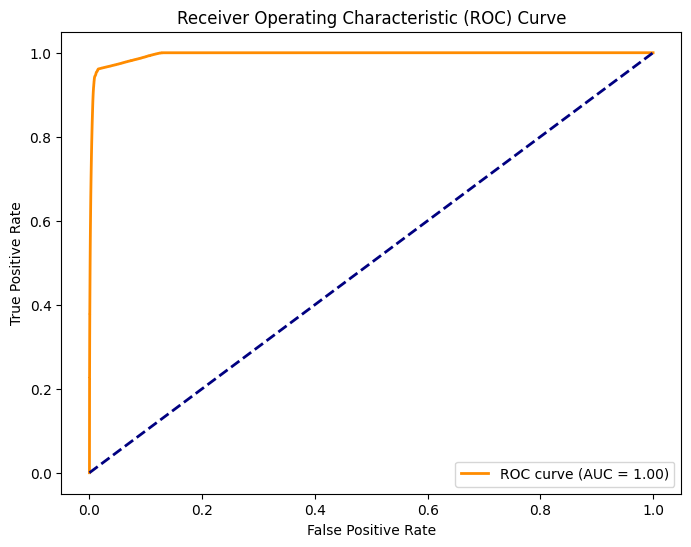

Рассмотрим тестовые данные (последний день) и сравним наши результаты с бейзлайном
Baseline accuracy: 1.0
Logistic Regression accuracy: 1.0


In [62]:
model = create_model(data)

In [63]:
def cv(data: pd.DataFrame):
    # Логистическая регрессия с L-BFGS оптимизатором
    model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs', 
                                   penalty='l2', fit_intercept=False)

    # Подберем параметр регуляризации и проведем кросс-валидацию с помощью GridSearchCV
    param_grid = {'C': [15, 5, 0.1, 0.01, 0.001]}
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=1, verbose=3)
    grid_search.fit(X_train, y_train)
    print("Лучший параметр регуляризации:", grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred_val = best_model.predict(X_validate)
    y_prob_val = best_model.predict_proba(X_validate)[:, 1]

    accuracy = accuracy_score(y_validate, y_pred_val)
    logloss = log_loss(y_validate, y_prob_val)
    roc_auc = roc_auc_score(y_validate, y_prob_val)

    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation Log Loss: {logloss:.4f}")
    print(f"Validation ROC AUC: {roc_auc:.4f}")
    print("Validation Classification Report:\n", classification_report(y_validate, y_pred_val))

    fpr, tpr, _ = roc_curve(y_validate, y_prob_val)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print("Рассмотрим тестовые данные (последний день) и сравним наши результаты с бейзлайном")
    baseline = (y_test == 0).sum() / len(y_test)
    print(f"Baseline accuracy: {baseline}")

    y_pred_test = best_model.predict(X_test)
    print(f'Logistic Regression accuracy: {accuracy_score(y_test, y_pred_test)}')
    
    return best_model


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..............................C=15;, score=0.995 total time=  28.3s
[CV 2/5] END ..............................C=15;, score=0.995 total time=  28.0s
[CV 3/5] END ..............................C=15;, score=0.995 total time=  28.1s
[CV 4/5] END ..............................C=15;, score=0.995 total time=  28.3s
[CV 5/5] END ..............................C=15;, score=0.995 total time=  28.3s
[CV 1/5] END ...............................C=5;, score=0.995 total time=  28.1s
[CV 2/5] END ...............................C=5;, score=0.995 total time=  27.5s
[CV 3/5] END ...............................C=5;, score=0.995 total time=  27.5s
[CV 4/5] END ...............................C=5;, score=0.995 total time=  27.5s
[CV 5/5] END ...............................C=5;, score=0.995 total time=  31.1s
[CV 1/5] END .............................C=0.1;, score=0.995 total time=  28.7s
[CV 2/5] END .............................C=0.1;,

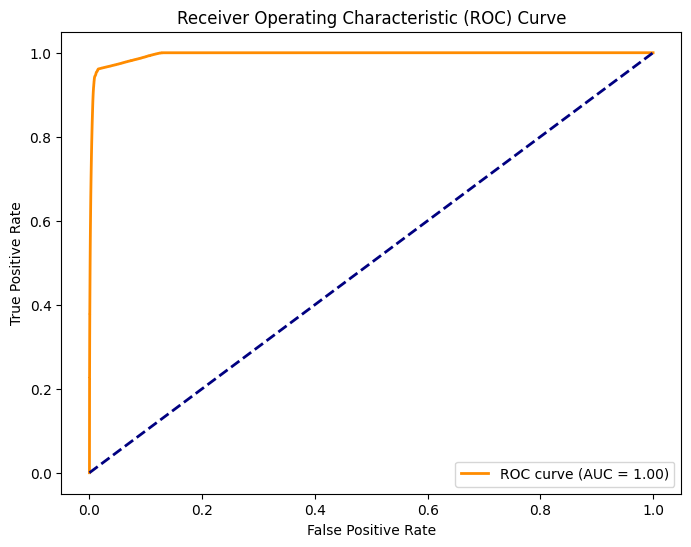

Рассмотрим тестовые данные (последний день) и сравним наши результаты с бейзлайном
Baseline accuracy: 1.0
Logistic Regression accuracy: 1.0


In [64]:
best_model = cv(data)